In [408]:
import numpy as np

class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = len(word2vec.itervalues().next())
    
    def fit(self, X, y):
        return self 

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec] 
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

In [409]:
import pandas as pd
from parse_dataset import parse_data

df_train = parse_data('/Users/enrico.t/code/ml-reference-implementations/data/babI/tasks_1-20_v1-2/en/qa1_single-supporting-fact_train.txt')
X_train = df_train['fact1'] + ' ' + df_train['fact2'] + ' ' + df_train['question']
y_train = df_train['answer']

df_test = parse_data('/Users/enrico.t/code/ml-reference-implementations/data/babI/tasks_1-20_v1-2/en/qa1_single-supporting-fact_test.txt')
X_test = df_test['fact1'] + ' ' + df_test['fact2'] + ' ' + df_test['question']
y_test = df_test['answer']

In [410]:
list_of_sentences = df_train[['fact1', 'fact2', 'question']].values
tokenised_sentences = reduce(
    lambda acc, doc: acc + [word_tokenize(sent) for sent in doc], 
    list_of_sentences, [])

In [411]:
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize

model = Word2Vec(tokenised_sentences, iter=5, alpha=0.1, size=100)
w2v = dict(zip(model.wv.index2word, model.wv.vectors))

print(model)
print(model.wv.vocab.keys())

Word2Vec(vocab=21, size=100, alpha=0.1)
['Mary', 'hallway', 'bathroom', 'journeyed', 'office', 'the', 'is', 'bedroom', 'moved', 'back', '.', 'to', 'Daniel', 'garden', 'Sandra', 'travelled', 'John', 'Where', 'went', '?', 'kitchen']


In [412]:
model.wv.most_similar('John')

[('Sandra', 0.9810729026794434),
 ('Daniel', 0.961772084236145),
 ('Mary', 0.9472049474716187),
 ('is', 0.6233294010162354),
 ('travelled', 0.56789231300354),
 ('to', 0.5455714464187622),
 ('.', 0.5206953287124634),
 ('moved', 0.5089603662490845),
 ('journeyed', 0.508916974067688),
 ('back', 0.5008315443992615)]

In [413]:
model.wv.most_similar('kitchen')

[('office', 0.9891893267631531),
 ('bedroom', 0.9875427484512329),
 ('bathroom', 0.9855877161026001),
 ('hallway', 0.9842265844345093),
 ('garden', 0.9737095832824707),
 ('back', 0.9411276578903198),
 ('to', 0.9333966970443726),
 ('the', 0.8643811941146851),
 ('moved', 0.8631339073181152),
 ('travelled', 0.7947424054145813)]

In [414]:
"""
PLAN (BabI task 1)

given input:
- fact 1   | John travelled to the hallway.
- fact 2   | Mary journeyed to the bathroom.
- question | Where is John?

output:
- answer   | hallway
"""

from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
    
model = Pipeline([
    ('w2v', MeanEmbeddingVectorizer(w2v)),
    ('clf', SVC(kernel='linear')),
])

model.fit(X_train, y_train)
y_predict = model.predict(X_test)

In [415]:
from pandas_ml import ConfusionMatrix

cm = ConfusionMatrix(y_test, y_predict)
cm.print_stats()

Confusion Matrix:

Predicted  bathroom  bedroom  garden  hallway  kitchen  office  __all__
Actual                                                                 
bathroom          0        0     149        0        0       0      149
bedroom           0        0     171        0        0       0      171
garden            0        0     187        0        0       0      187
hallway           0        0     154        0        0       0      154
kitchen           0        0     157        0        0       0      157
office            0        0     182        0        0       0      182
__all__           0        0    1000        0        0       0     1000


Overall Statistics:

Accuracy: 0.187
95% CI: (0.16328321992459802, 0.21257507953143617)
No Information Rate: ToDo
P-Value [Acc > NIR]: 1.0
Kappa: 0.0
Mcnemar's Test P-Value: ToDo


Class Statistics:

Classes                               bathroom bedroom   garden hallway  \
Population                                1000    1000  

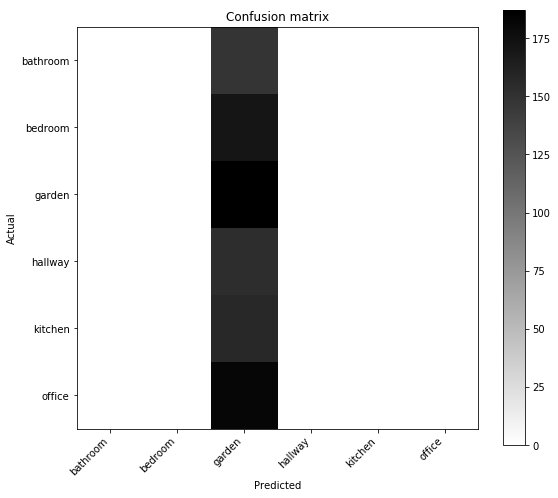

In [416]:
cm.plot()